## Modelisation - Segmentation des images urbaines en utilisant le Dataset CityScapes.

### Sommaire
1. Import Packages
2. Preparations donnees
3. Préparation des données
4. Modélisations
    1. Mini-Unet
    2. Mini-Unet, Fonction Dice Loss
    3. Mini-Unet, Fonction Total Loss
    4. Mini-Unet, avec Augmentation des données
    5. ResNet50
    6. Resnet50, avec Augmentation des données
    7. VGG16
    8. VGG19
5. Comparaison des modèles
6. Choix du modèle

Dans ce notebook, nous allons entreprendre la phase de la modélisation de notre projet. Cette étape implique la construction et l'entraînement de plusieurs modèles d'apprentissage automatique, en utilisant les données que nous avons préparées et explorées dans les étapes précédentes.

Nous allons commencer par définir une série de modèles candidats, puis nous allons les entraîner sur nos données d'apprentissage. Cela impliquera probablement un certain degré de réglage des hyperparamètres pour chaque modèle, afin de trouver la configuration qui donne les meilleurs résultats sur nos données.

Ensuite, nous évaluerons chaque modèle sur nos données de test. Cela nous permettra de voir comment chaque modèle se généralise à de nouvelles données, ce qui est un indicateur clé de la performance d'un modèle.

Enfin, nous comparerons les performances de tous nos modèles. Cela nous permettra de choisir le modèle qui semble le plus prometteur pour notre problème. Ce choix sera basé sur une combinaison de facteurs, y compris la précision de la prédiction, la robustesse du modèle, et d'autres considérations pertinentes.


### 1. Import libraries

Tous d'abord, nous avons commencé par importer les bibliothèques nécessaires pour notre analyse et notre modélisation. Voici une brève description de ce que chaque bibliothèque fait :

- `os` : Cette bibliothèque nous permet d'interagir avec le système d'exploitation, par exemple pour manipuler les chemins de fichiers.
- `cv2` : OpenCV (cv2) est une bibliothèque de fonctions de programmation orientée vers la vision par ordinateur en temps réel.
- `numpy` et `pandas` : Ces bibliothèques sont utilisées pour la manipulation de données. Numpy nous permet de travailler avec des tableaux multidimensionnels, tandis que pandas est utilisé pour la manipulation de données structurées.
- `matplotlib.pyplot` : Nous utilisons cette bibliothèque pour créer des visualisations de nos données.
- `importlib` : Cette bibliothèque est utilisée pour recharger nos modules personnalisés afin que les modifications apportées aux scripts soient prises en compte.
- `tensorflow` : C'est la bibliothèque que nous utilisons pour construire et entraîner nos modèles de deep learning.
- `sys` : Nous utilisons cette bibliothèque pour ajouter le chemin de notre script à la liste des chemins où Python recherche les modules lors de l'importation.
- `functions`, `Datagenerator` et `model` : Ce sont nos modules personnalisés. Nous les rechargeons à chaque fois pour nous assurer que toutes les modifications apportées aux scripts sont prises en compte.

Après avoir importé toutes les bibliothèques nécessaires, nous vérifions la version de TensorFlow pour nous assurer que nous travaillons avec la version correcte.

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib

import concurrent.futures

import tensorflow as tf

print("tensorflow version", tf.__version__)

import sys

sys.path.append("../script/")
import functions as fc


import Datagenerator as dg
import model as md

importlib.reload(fc)
importlib.reload(md)
importlib.reload(dg)

tensorflow version 2.10.0


<module 'Datagenerator' from 'c:\\Users\\Zacca\\OneDrive\\Desktop\\ociap8\\notebook\\../script\\Datagenerator.py'>

In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


### 2. Préparation données

#### 2.1 Import données

Ci dessous , nous définissons les chemins vers les données brutes et les ensembles de données spécifiques.

Tout d'abord, nous définissons ``processed_data_path`` comme le chemin vers le dossier où nous stockons les images traitées. Nous vérifions ensuite si ce dossier existe déjà. Si c'est le cas, nous utilisons ces images traitées pour notre analyse et notre modélisation. Sinon, nous utilisons les images brutes stockées dans le dossier ``../data/raw.``

Ensuite, nous définissons ``leftImg8bit_path`` et ``gtFine_path`` comme les chemins vers les sous-dossiers spécifiques contenant les images ``leftImg8bit`` et ``gtFine``, respectivement. Ces chemins sont définis en fonction de l'endroit où nous avons décidé de prendre nos images (traitées ou brutes).

In [4]:
# Define the paths to the raw data and specific datasets
processed_data_path = "../data/processed/res_data/"
if os.path.exists(processed_data_path):
    raw_data_path = processed_data_path
    print("Using processed images from ../data/processed/res_data/")
else:
    raw_data_path = "../data/raw"
    print("Using raw images from ../data/raw")

leftImg8bit_path = os.path.join(raw_data_path, "leftImg8bit/")
gtFine_path = os.path.join(raw_data_path, "gtFine/")

Using processed images from ../data/processed/res_data/


#### 2.2 Définition des paramètres

Maintenant nous allons définir des paramètres ques nous allons utiliser.
Tout d'abord, nous définissons ``DIM_X`` et ``DIM_Y`` comme les dimensions de nos images. Ces valeurs sont fixées à 256, ce qui signifie que nous allons travailler avec des images de taille 256x256 pixels.

Ensuite, nous définissons ``INPUT_SHAPE`` comme étant la forme de l'entrée de notre modèle. Dans ce cas, il s'agit d'un tuple de trois valeurs : ``DIM_X``, ``DIM_Y`` et 3. Les deux premières valeurs sont les dimensions de l'image, et la troisième valeur (3) correspond aux trois canaux de couleur (rouge, vert et bleu) de l'image.

Enfin, nous définissons ``N_CLASS`` comme le nombre de classes de sortie de notre modèle. Dans ce cas, nous avons 8 classes, ce qui signifie que notre modèle sera entraîné pour classer les images en 8 catégories différentes.

In [5]:
# Définir dimensions images
DIM_X = 256
DIM_Y = 256
INPUT_SHAPE = (DIM_X, DIM_Y, 3)
# définition class de sortie
N_CLASS = 8

### 3. Préparation des données

#### 3.1 Récuperer les chemins d'accès aux images et prépartion echantillon de test

Nous préparons maintenants les chemins vers les images et les masques que nous allons utiliser pour l'entraînement, le test et la validation de notre modèle.

Tout d'abord, nous utilisons la fonction `getPathFiles` de notre module personnalisé `fc` pour obtenir les chemins vers les images (`x_train_path`, `x_test_path`, `x_val_path`) et les masques (`y_train_path`, `y_test_path`, `y_val_path`). Les images sont stockées dans le dossier `leftImg8bit_path` et les masques dans le dossier `gtFine_path`.

Ensuite, nous préparons un échantillon de nos données de test pour une utilisation ultérieure. Nous utilisons la fonction `get_data_prepared` de notre module `fc` pour cela. Nous passons les dix premiers chemins d'images et de masques de test (`x_test_path[0:10]`, `y_test_path[0:10]`) ainsi que les dimensions de nos images (`DIM_X`, `DIM_Y`). Les données préparées sont stockées dans `X_test` et `y_test`.

In [6]:
# Listes des chemins des images
x_train_path, x_test_path, x_val_path = fc.getPathFiles(leftImg8bit_path)
# Listes des chemins des masques
y_train_path, y_test_path, y_val_path = fc.getPathFiles(gtFine_path, "labelIds.png")

# Echantillon préparé pour les tests
X_test, y_test = fc.get_data_prepared(
    x_test_path[0:10], y_test_path[0:10], (DIM_X, DIM_Y)
)

#### 3.2 Resize des images

Tout d'abord, nous définissons `data_res_path` comme le chemin vers le dossier où nous voulons stocker les images redimensionnées. Nous vérifions ensuite si ce dossier existe déjà. Si ce n'est pas le cas, nous le créons.

Ensuite, nous itérons sur les dossiers dans `../data/raw`. Pour chaque sous-dossier qui n'est pas `img` ou `.DS_Store` et qui est un répertoire, nous créons un sous-dossier correspondant dans `data_res_path`. Nous faisons de même pour tous les sous-dossiers de ces sous-dossiers.

Après cela, nous combinons tous les chemins d'images et de masques dans `all_images_path` et nous imprimons le nombre total d'images à traiter.

Ensuite, nous itérons sur tous les chemins dans `all_images_path`. Pour chaque chemin qui ne contient pas `.DS_Store`, nous lisons l'image, la redimensionnons à 1024x512 pixels, et l'enregistrons dans le nouveau répertoire. Si l'image ne peut pas être lue, nous imprimons un message d'erreur et passons à l'image suivante.

Si le dossier `data_res_path` existe déjà, nous imprimons un message indiquant que le dossier existe déjà.

Il est important de noter que le redimensionnement des images peut avoir un impact négatif sur les performances du modèle car il réduit le niveau de détail des images. Cependant, cela améliore considérablement les temps d'entraînement car il y a moins de détails à traiter. Cela nous permet de tester plus facilement plus de modèles sans consommer trop de ressources.

In [7]:
data_res_path = "../data/processed/res_data"

# Check if the directory already exists
if not os.path.exists(data_res_path):
    os.mkdir(data_res_path)

    # Iterate over the directories in 'data/raw'
    for dir_1 in os.listdir("../data/raw"):
        if (
            dir_1 != "img"
            and dir_1 != ".DS_Store"
            and os.path.isdir(os.path.join("../data/raw", dir_1))
        ):
            os.mkdir(os.path.join(data_res_path, dir_1))
            for dir_2 in os.listdir(os.path.join("../data/raw", dir_1)):
                if dir_2 != ".DS_Store":
                    os.mkdir(os.path.join(data_res_path, dir_1, dir_2))
                    for dir_3 in os.listdir(os.path.join("../data/raw", dir_1, dir_2)):
                        if dir_3 != ".DS_Store":
                            os.mkdir(os.path.join(data_res_path, dir_1, dir_2, dir_3))

    all_images_path = (
        x_train_path
        + x_test_path
        + x_val_path
        + y_train_path
        + y_test_path
        + y_val_path
    )

    print(f"Number of images to process: {len(all_images_path)}")

    # Resize and save the images in the new directory
    for path in all_images_path:
        if ".DS_Store" not in path:
            img = cv2.imread(path)
            if img is None:
                print(f"Failed to read image at {path}")
                continue
            img = cv2.resize(img, (1024, 512))
            new_path = path.replace(raw_data_path, "../data/processed/res_data")
            cv2.imwrite(new_path, img)
            print(f"Saved resized image to {new_path}")

else:
    print(f"Dossier {data_res_path} existe déjà")

Dossier ../data/processed/res_data existe déjà


#### 3.3 Data Augmentation 

Maintenant nous chargeons et traitons les images et les masques, puis nous augmentons les données d'entraînement.

Tout d'abord, nous définissons deux fonctions, `load_and_process_image` et `load_and_process_mask`, qui chargent et traitent respectivement une image et un masque. Ces fonctions utilisent la bibliothèque `cv2` pour lire l'image ou le masque, puis redimensionnent l'image ou le masque à la taille spécifiée (`DIM_X`, `DIM_Y`). Pour le masque, nous utilisons également la fonction `convert_mask` de notre module personnalisé `fc` pour convertir le masque en une forme appropriée.

Ensuite, nous utilisons un `ThreadPoolExecutor` du module `concurrent.futures` pour charger et traiter les images et les masques en parallèle. Cela nous permet d'accélérer le processus de chargement et de traitement des images et des masques. Nous utilisons la méthode `map` de l'executor pour appliquer les fonctions `load_and_process_image` et `load_and_process_mask` à `x_train_path[:3]` et `y_train_path[:3]` respectivement. Les résultats sont convertis en tableaux numpy et stockés dans `X` et `y`.

Ensuite, nous utilisons la fonction `augment_data` de notre module `fc` pour augmenter les données d'entraînement. Les données augmentées sont stockées dans `X_augmented` et `y_augmented`.

Enfin, nous convertissons les masques augmentés en une forme où chaque pixel est l'indice de la classe à laquelle il appartient. Nous utilisons la fonction `argmax` de numpy pour cela et stockons le résultat dans `y_augmented_arg`.

La fonction `augment_data` prend en entrée deux tableaux numpy `X` et `y` qui représentent respectivement les images et les masques d'image à augmenter. Chaque image est un tableau numpy 3D et chaque masque est un tableau numpy 2D ou 3D.

La fonction utilise la bibliothèque `imgaug` pour appliquer une transformation d'augmentation de données sur les images et les masques. La transformation appliquée est une symétrie verticale, qui est appliquée à toutes les images (`iaa.Fliplr(1.0)`). Comme il n'y a qu'une seule transformation, l'ordre des transformations n'est pas randomisé (`random_order=False`).

Pour chaque image et masque dans `X` et `y`, la fonction crée une carte de segmentation à partir du masque, applique la transformation d'augmentation à l'image et à la carte de segmentation, redimensionne l'image et le masque augmentés à la taille originale de l'image, et ajoute l'image et le masque augmentés à `new_X` et `new_y` respectivement.

La fonction retourne un tuple contenant deux tableaux numpy. Le premier tableau contient les images augmentées et le deuxième tableau contient les masques d'image augmentés correspondants.

In [8]:
def load_and_process_image(path_X):
    return cv2.resize(cv2.imread(path_X), (DIM_X, DIM_Y))


def load_and_process_mask(path_y):
    return cv2.resize(fc.convert_mask(cv2.imread(path_y, 0)), (DIM_X, DIM_Y))


with concurrent.futures.ThreadPoolExecutor() as executor:
    X = np.array(list(executor.map(load_and_process_image, x_train_path[:3])))
    y = np.array(list(executor.map(load_and_process_mask, y_train_path[:3])))

# Augment the training data and mask.
X_augmented, y_augmented = fc.augment_data(X, y)

# Convert the augmented masks into a form where each pixel is the index of the class it belongs to.
y_augmented_arg = np.argmax(y_augmented, axis=3)

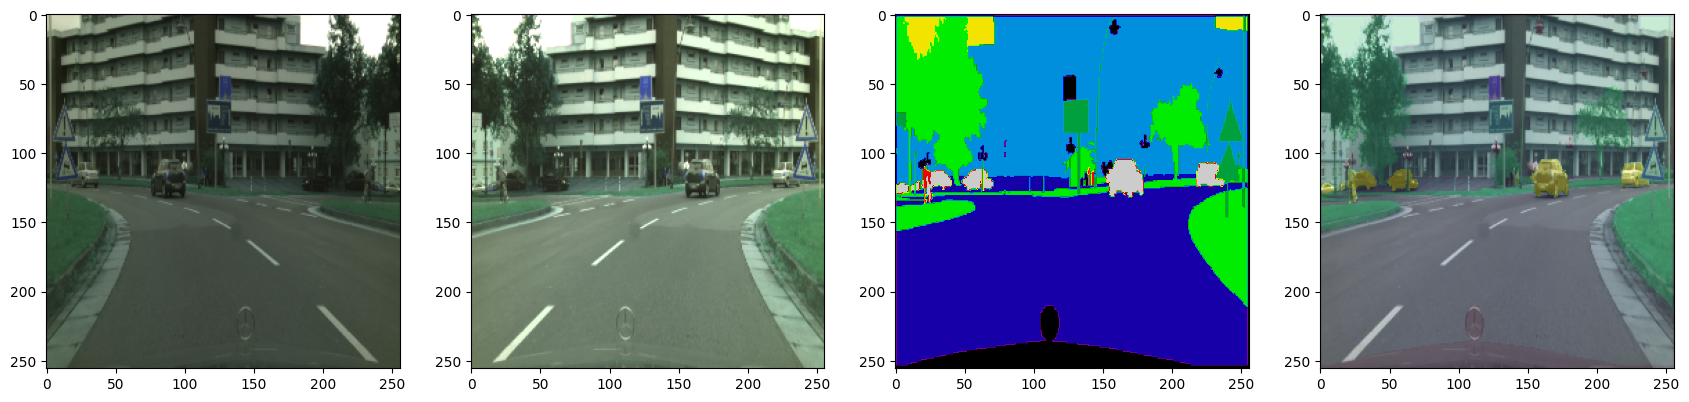

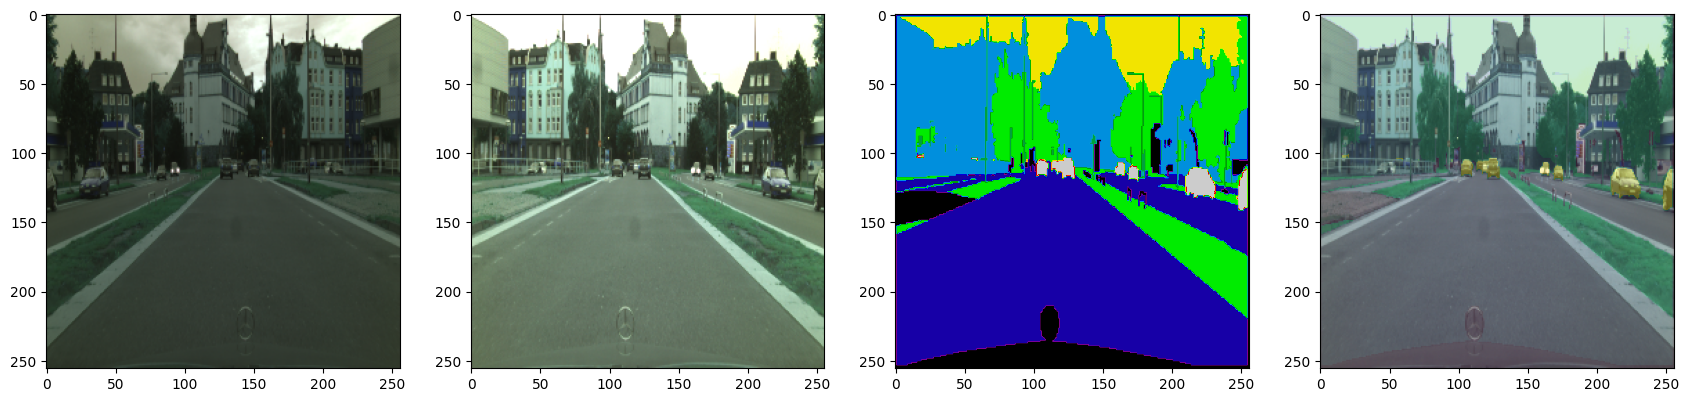

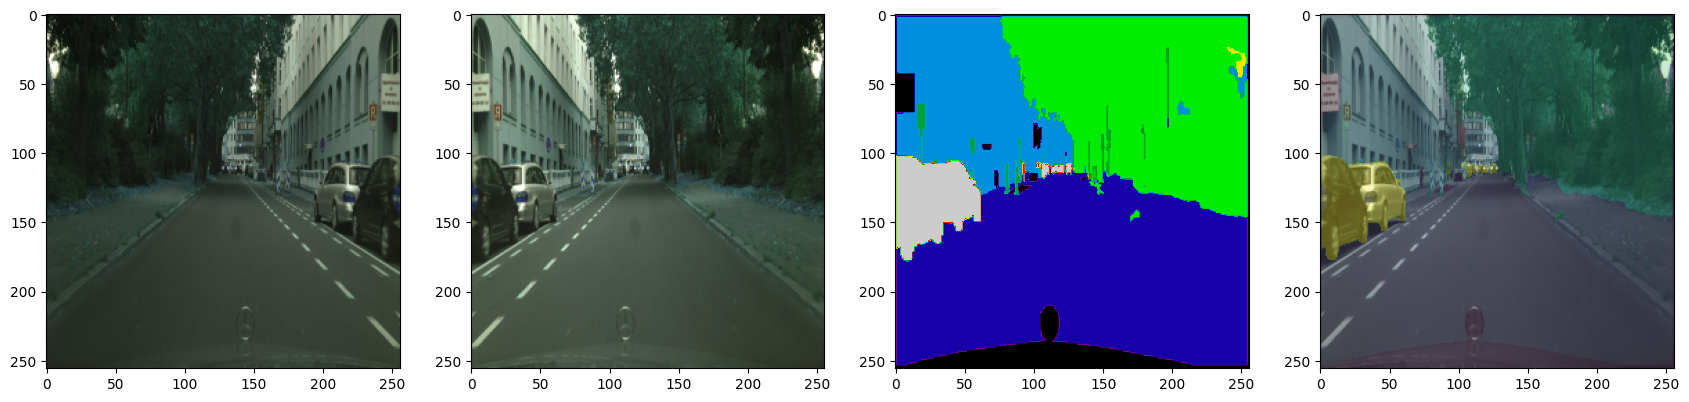

In [9]:
for i in range(len(X)):
    plt.subplots(1, 4, figsize=(21, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(X[i])

    plt.subplot(1, 4, 2)
    plt.imshow(X_augmented[i])

    plt.subplot(1, 4, 3)
    plt.imshow(y_augmented_arg[i], cmap="nipy_spectral")

    plt.subplot(1, 4, 4)
    plt.imshow(X_augmented[i])
    plt.imshow(y_augmented_arg[i], alpha=0.3)

    plt.show()

#### 3.3 Data Generator

Dans ce bloc de code, quatre instances de la classe `DataGenerator` sont créées pour générer des lots de données d'entraînement et de validation, avec et sans augmentation des données.

La classe `DataGenerator` est définie dans le module `dg`. Elle prend en entrée les chemins vers les images et les masques, la taille du lot, les dimensions des images et un booléen indiquant si les données doivent être augmentées ou non.

- `data_train` : Un `DataGenerator` pour les données d'entraînement sans augmentation des données. La taille du lot est de 20 et les dimensions des images sont `(DIM_X, DIM_Y)`.
- `data_val` : Un `DataGenerator` pour les données de validation sans augmentation des données. La taille du lot est de 20 et les dimensions des images sont `(DIM_X, DIM_Y)`.
- `data_train_augmented` : Un `DataGenerator` pour les données d'entraînement avec augmentation des données. La taille du lot est de 10 et les dimensions des images sont `(DIM_X, DIM_Y)`.
- `data_val_augmented` : Un `DataGenerator` pour les données de validation avec augmentation des données. La taille du lot est de 10 et les dimensions des images sont `(DIM_X, DIM_Y)`.

Ces `DataGenerator` seront utilisés pour alimenter le modèle d'apprentissage profond avec des lots de données d'entraînement et de validation lors de l'entraînement du modèle.

In [10]:
# Création d'un DataGenerator pour les données d'entraînement sans augmentation des données.
data_train = dg.DataGenerator(
    x_train_path, y_train_path, batch_size=20, dim=(DIM_X, DIM_Y), augmentation=False
)

# Création d'un DataGenerator pour les données de validation sans augmentation des données.
data_val = dg.DataGenerator(
    x_val_path, y_val_path, batch_size=20, dim=(DIM_X, DIM_Y), augmentation=False
)

# Création d'un DataGenerator pour les données d'entraînement avec augmentation des données.
data_train_augmented = dg.DataGenerator(
    x_train_path, y_train_path, batch_size=10, dim=(DIM_X, DIM_Y), augmentation=True
)

# Création d'un DataGenerator pour les données de validation avec augmentation des données.
data_val_augmented = dg.DataGenerator(
    x_val_path, y_val_path, batch_size=10, dim=(DIM_X, DIM_Y), augmentation=True
)

### 4 Modélisation

### 4.1 Mini U-net

Un Mini U-Net est une version simplifiée du réseau neuronal convolutif U-Net, qui est largement utilisé pour les tâches de segmentation d'images. Le U-Net original est un réseau de type encodeur-décodeur avec des connexions de saut qui permettent une localisation précise.

Le Mini U-Net conserve la structure générale de l'U-Net, mais avec moins de couches convolutives, ce qui le rend plus léger et plus rapide à entraîner. Malgré sa simplicité, il peut toujours réaliser des performances de segmentation d'images assez précises, en particulier sur des ensembles de données plus petits ou moins complexes.

1. `model = md.build_mini_unet(INPUT_SHAPE, N_CLASS)`: Cette ligne crée un modèle U-Net en utilisant la fonction `build_mini_unet` du module `md`. Les paramètres `INPUT_SHAPE` et `N_CLASS` sont passés à cette fonction. `INPUT_SHAPE` est la forme de l'entrée que le modèle doit accepter et `N_CLASS` est le nombre de classes que le modèle doit prédire.

2. `model_name = model.name + "_basic"`: Cette ligne crée une nouvelle variable `model_name` qui est une concaténation du nom du modèle et de la chaîne "_basic". Cela est probablement fait pour distinguer ce modèle de base d'autres versions du modèle qui pourraient être créées plus tard.

3. `model.summary()`: Cette ligne affiche un résumé du modèle. Le résumé comprend le nombre total de paramètres du modèle, le nombre de paramètres entraînables et non entraînables, et une représentation de chaque couche du modèle, y compris sa forme de sortie et le nombre de paramètres qu'elle a.

En résumé, ce code crée un modèle de base U-Net, lui donne un nom spécifique et affiche un résumé du modèle.

In [11]:
# Build model
model = md.build_mini_unet(INPUT_SHAPE, N_CLASS)
model_name = model.name + "_basic"
model.summary()

Model: "Mini_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                        

In [12]:
# Train model
print(f"Modèle : {model_name}")
model, hist_df, training_time = fc.train_model(
    model,
    model_name,
    data_train,
    data_train_augmented,
    data_val_augmented,
    data_val,
    X_test,
    "categorical_crossentropy",
    False,
)

Modèle : Mini_U-Net_basic
Epoch 1/20
148/148 [==============================] - 60s 376ms/step - loss: 2.1412 - mean_iou: 0.0724 - val_loss: 2.1059 - val_mean_iou: 0.0571
Epoch 2/20
148/148 [==============================] - 58s 389ms/step - loss: 2.0381 - mean_iou: 0.0860 - val_loss: 2.0526 - val_mean_iou: 0.0825
Epoch 3/20
148/148 [==============================] - 58s 391ms/step - loss: 1.9709 - mean_iou: 0.0964 - val_loss: 1.9934 - val_mean_iou: 0.0929
Epoch 4/20
148/148 [==============================] - 58s 391ms/step - loss: 1.9073 - mean_iou: 0.1046 - val_loss: 1.9238 - val_mean_iou: 0.1005
Epoch 5/20
148/148 [==============================] - 58s 390ms/step - loss: 1.8565 - mean_iou: 0.1148 - val_loss: 1.8649 - val_mean_iou: 0.1094
Epoch 6/20
148/148 [==============================] - 58s 389ms/step - loss: 1.8102 - mean_iou: 0.1270 - val_loss: 1.8228 - val_mean_iou: 0.1190
Epoch 7/20
148/148 [==============================] - 57s 379ms/step - loss: 1.7673 - mean_iou: 0.1448 -

INFO:tensorflow:Assets written to: ../model/checkpoint/Mini_U-Net_basic\assets


INFO:tensorflow:Assets written to: ../model/checkpoint/Mini_U-Net_basic\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpws0shrq8\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpws0shrq8\assets


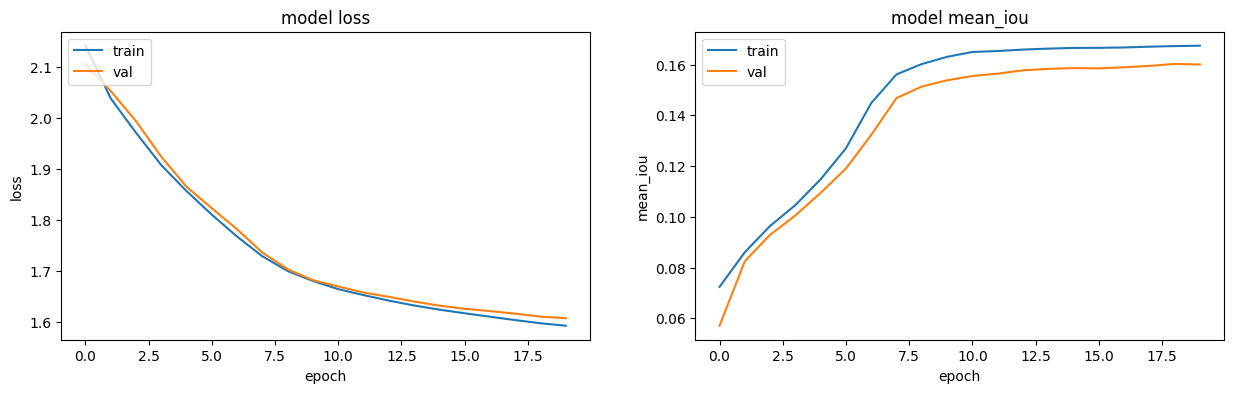

In [13]:
# Draw loss function and metric evolution
fc.draw_history(hist_df)

In [14]:
# Predict from model trained
y_pred_argmax = fc.predict_model(
    model,
    model_name,
    X_test,
    data_val,
    "categorical_crossentropy",
    training_time,
    show_pred=False,
)

25/25 [==============================] - 16s 634ms/step - loss: 1.6106 - mean_iou: 0.1603
Pour le meilleur modèle on obtient :
mean_iou : 0.160254567861557
loss : 1.610632300376892
1/1 [==============================] - 0s 251ms/step


#### 4.2 Mini U-net, fonction dice loss

La fonction de ``Dice loss`` est une métrique couramment utilisée pour les problèmes de segmentation d'images, en particulier pour les problèmes où les classes sont très déséquilibrées. Elle mesure l'overlap entre les prédictions du modèle et les vérités terrain. Une valeur de 1 indique une correspondance parfaite entre les prédictions et les vérités terrain, tandis qu'une valeur de 0 indique aucune correspondance.


In [15]:
# Build model
model = md.build_mini_unet(INPUT_SHAPE, N_CLASS)
model_name = model.name + "_dice_loss"

In [16]:
# Train model
print(f"Modèle : {model_name}")
model, hist_df, training_time = fc.train_model(
    model,
    model_name,
    data_train,
    data_train_augmented,
    data_val_augmented,
    data_val,
    X_test,
    fc.dice_loss,
    False,
)

Modèle : Mini_U-Net_dice_loss
Epoch 1/20
148/148 [==============================] - 61s 402ms/step - loss: 0.8695 - mean_iou: 0.0456 - val_loss: 0.8720 - val_mean_iou: 0.0521
Epoch 2/20
148/148 [==============================] - 58s 392ms/step - loss: 0.8523 - mean_iou: 0.1018 - val_loss: 0.8602 - val_mean_iou: 0.0661
Epoch 3/20
148/148 [==============================] - 58s 389ms/step - loss: 0.8398 - mean_iou: 0.1125 - val_loss: 0.8476 - val_mean_iou: 0.1032
Epoch 4/20
148/148 [==============================] - 58s 388ms/step - loss: 0.8299 - mean_iou: 0.1137 - val_loss: 0.8346 - val_mean_iou: 0.0997
Epoch 5/20
148/148 [==============================] - 58s 392ms/step - loss: 0.8207 - mean_iou: 0.1151 - val_loss: 0.8213 - val_mean_iou: 0.1021
Epoch 6/20
148/148 [==============================] - 58s 391ms/step - loss: 0.8078 - mean_iou: 0.1156 - val_loss: 0.8024 - val_mean_iou: 0.1032
Epoch 7/20
148/148 [==============================] - 59s 392ms/step - loss: 0.7928 - mean_iou: 0.11

INFO:tensorflow:Assets written to: ../model/checkpoint/Mini_U-Net_dice_loss\assets


INFO:tensorflow:Assets written to: ../model/checkpoint/Mini_U-Net_dice_loss\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmp1r65vy_3\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmp1r65vy_3\assets


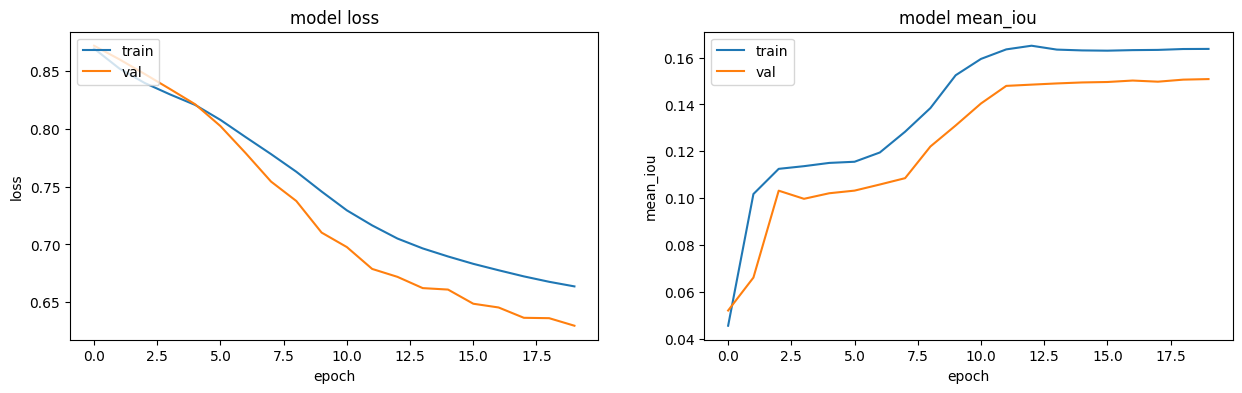

In [17]:
# Draw loss function and metric evolution
fc.draw_history(hist_df)

In [18]:
# Predict from model trained
y_pred_argmax = fc.predict_model(
    model,
    model_name,
    X_test,
    data_val,
    fc.dice_loss,
    training_time,
    show_pred=False,
)

25/25 [==============================] - 16s 633ms/step - loss: 0.6297 - mean_iou: 0.1508
Pour le meilleur modèle on obtient :
mean_iou : 0.1508338749408722
loss : 0.6296670436859131
1/1 [==============================] - 0s 87ms/step


#### 4.3 Model Mini U-Net Total Loss

La fonction de ``Total loss`` est généralement une combinaison de plusieurs autres fonctions de perte, utilisée pour optimiser plusieurs aspects du modèle simultanément. Par exemple, dans un problème de segmentation d'images, la perte totale pourrait être une combinaison de la perte de Dice (pour mesurer l'overlap entre les prédictions et les vérités terrain) et la perte de cross-entropy (pour mesurer l'erreur de classification).

In [19]:
# Build model
model = md.build_mini_unet(INPUT_SHAPE, N_CLASS)
model_name = model.name + "_total_loss"

In [20]:
# Train model
print(f"Modèle : {model_name}")
model, hist_df, training_time = fc.train_model(
    model,
    model_name,
    data_train,
    data_train_augmented,
    data_val_augmented,
    data_val,
    X_test,
    fc.total_loss,
    False,
)

Modèle : Mini_U-Net_total_loss
Epoch 1/20
148/148 [==============================] - 61s 402ms/step - loss: 4.7613 - mean_iou: 0.0450 - val_loss: 4.7236 - val_mean_iou: 0.0485
Epoch 2/20
148/148 [==============================] - 59s 396ms/step - loss: 4.6317 - mean_iou: 0.0941 - val_loss: 4.6469 - val_mean_iou: 0.0732
Epoch 3/20
148/148 [==============================] - 59s 397ms/step - loss: 4.5328 - mean_iou: 0.1065 - val_loss: 4.5411 - val_mean_iou: 0.1046
Epoch 4/20
148/148 [==============================] - 59s 395ms/step - loss: 4.4612 - mean_iou: 0.1083 - val_loss: 4.4580 - val_mean_iou: 0.1072
Epoch 5/20
148/148 [==============================] - 59s 395ms/step - loss: 4.4098 - mean_iou: 0.1119 - val_loss: 4.4034 - val_mean_iou: 0.1075
Epoch 6/20
148/148 [==============================] - 58s 392ms/step - loss: 4.3625 - mean_iou: 0.1170 - val_loss: 4.3534 - val_mean_iou: 0.1093
Epoch 7/20
148/148 [==============================] - 59s 396ms/step - loss: 4.3153 - mean_iou: 0.1

INFO:tensorflow:Assets written to: ../model/checkpoint/Mini_U-Net_total_loss\assets


INFO:tensorflow:Assets written to: ../model/checkpoint/Mini_U-Net_total_loss\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpobxy4d_9\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpobxy4d_9\assets


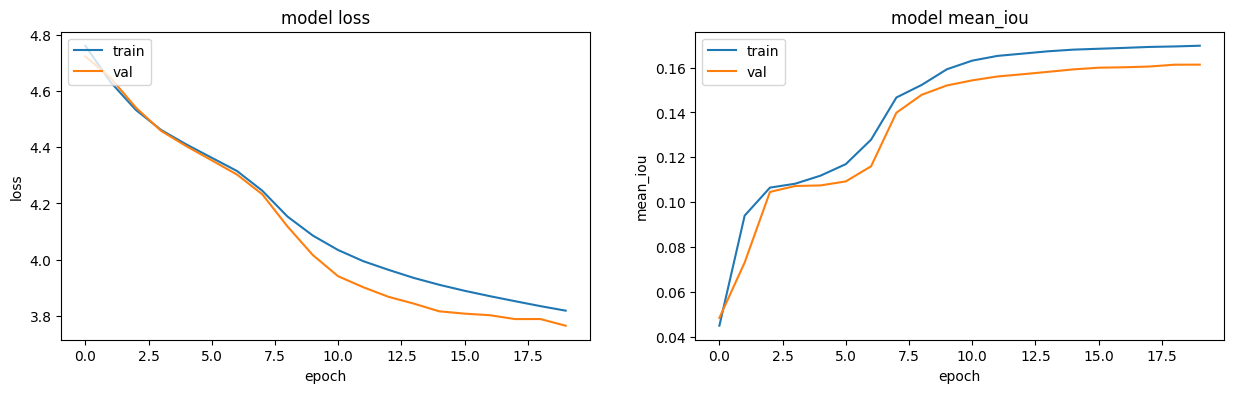

In [21]:
# Draw loss function and metric evolution
fc.draw_history(hist_df)

In [22]:
# Predict from model trained
y_pred_argmax = fc.predict_model(
    model,
    model_name,
    X_test,
    data_val,
    fc.total_loss,
    training_time,
    show_pred=False,
)

25/25 [==============================] - 16s 624ms/step - loss: 3.7645 - mean_iou: 0.1613
Pour le meilleur modèle on obtient :
mean_iou : 0.1612766683101654
loss : 3.7644948959350586
1/1 [==============================] - 0s 85ms/step


### 4.4 Modèle Mini Unet avec augmentation des données

L'augmentation des données est une technique couramment utilisée pour augmenter la taille et la diversité de l'ensemble de données d'entraînement. Elle implique la création de nouvelles données d'entraînement en appliquant diverses transformations aux données existantes, comme la rotation, le décalage, le zoom et le retournement. Cela peut aider à améliorer la performance du modèle et à prévenir le surapprentissage, en particulier lorsque l'ensemble de données d'origine est petit.

In [23]:
# Build model
model = md.build_mini_unet(INPUT_SHAPE, N_CLASS)
model_name = model.name + "_augmentation"

In [24]:
# Train model
print(f"Modèle : {model_name}")
model, hist_df, training_time = fc.train_model(
    model,
    model_name,
    data_train,
    data_train_augmented,
    data_val_augmented,
    data_val,
    X_test,
    fc.total_loss,
    True,
)

Modèle : Mini_U-Net_augmentation
Epoch 1/20
297/297 [==============================] - 65s 214ms/step - loss: 4.5805 - mean_iou: 0.1185 - val_loss: 4.5261 - val_mean_iou: 0.1067
Epoch 2/20
297/297 [==============================] - 64s 215ms/step - loss: 4.2621 - mean_iou: 0.1394 - val_loss: 4.2225 - val_mean_iou: 0.1305
Epoch 3/20
297/297 [==============================] - 64s 215ms/step - loss: 4.0715 - mean_iou: 0.1527 - val_loss: 4.0489 - val_mean_iou: 0.1432
Epoch 4/20
297/297 [==============================] - 64s 215ms/step - loss: 3.9085 - mean_iou: 0.1753 - val_loss: 3.8943 - val_mean_iou: 0.1657
Epoch 5/20
297/297 [==============================] - 64s 215ms/step - loss: 3.7791 - mean_iou: 0.1896 - val_loss: 3.7606 - val_mean_iou: 0.1796
Epoch 6/20
297/297 [==============================] - 66s 220ms/step - loss: 3.6418 - mean_iou: 0.2070 - val_loss: 3.5847 - val_mean_iou: 0.1999
Epoch 7/20
297/297 [==============================] - 66s 222ms/step - loss: 3.5331 - mean_iou: 0

INFO:tensorflow:Assets written to: ../model/checkpoint/Mini_U-Net_augmentation\assets


INFO:tensorflow:Assets written to: ../model/checkpoint/Mini_U-Net_augmentation\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpyedy6be5\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpyedy6be5\assets


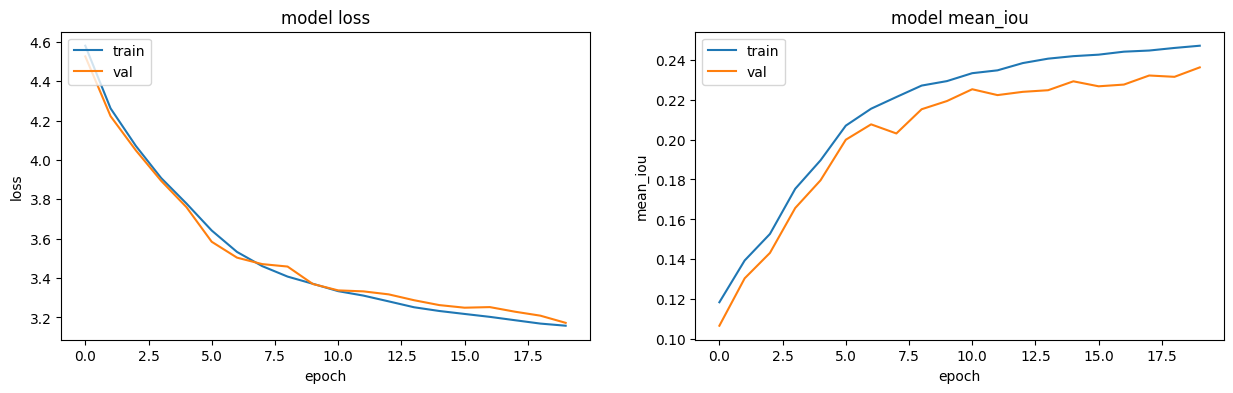

In [25]:
# Draw loss function and metric evolution
fc.draw_history(hist_df)

In [26]:
# Predict from model trained
y_pred_argmax = fc.predict_model(
    model,
    model_name,
    X_test,
    data_val,
    "total_loss",
    training_time,
    show_pred=False,
)

25/25 [==============================] - 16s 628ms/step - loss: 3.5622 - mean_iou: 0.1557
Pour le meilleur modèle on obtient :
mean_iou : 0.15567710995674133
loss : 3.56223726272583
1/1 [==============================] - 0s 87ms/step


### 4.5 Modèles Resnet50 Unet

ResNet50 U-Net est une architecture de réseau neuronal qui combine ResNet50 et U-Net. ResNet50 est une version de ResNet, un réseau neuronal convolutif profond qui utilise des connexions résiduelles pour éviter les problèmes de disparition de gradient lors de l'entraînement de réseaux profonds. U-Net est une architecture de réseau neuronal convolutif pour la segmentation d'images qui utilise une structure d'encodeur-décodeur avec des connexions de saut.

En combinant ces deux architectures, ResNet50 U-Net peut bénéficier de la capacité de ResNet50 à apprendre des caractéristiques hiérarchiques profondes et de la capacité de U-Net à localiser précisément les objets dans l'image.

1. `model = md.build_resnet50(INPUT_SHAPE, N_CLASS)`: Cette ligne crée un modèle ResNet50 U-Net en utilisant la fonction `build_resnet50` du module `md`. Les paramètres `INPUT_SHAPE` et `N_CLASS` sont passés à cette fonction. `INPUT_SHAPE` est la forme de l'entrée que le modèle doit accepter et `N_CLASS` est le nombre de classes que le modèle doit prédire.

2. `model_name = model.name + "_basic"`: Cette ligne crée une nouvelle variable `model_name` qui est une concaténation du nom du modèle et de la chaîne "_basic". Cela est probablement fait pour distinguer ce modèle de base d'autres versions du modèle qui pourraient être créées plus tard.

In [27]:
# Build model
model = md.build_resnet50(INPUT_SHAPE, N_CLASS)
model_name = model.name + "_basic"

In [28]:
# Train model
print(f"Modèle : {model_name}")
model, hist_df, training_time = fc.train_model(
    model,
    model_name,
    data_train,
    data_train_augmented,
    data_val_augmented,
    data_val,
    X_test,
    fc.total_loss,
    False,
)

Modèle : ResNet50_U-Net_basic
Epoch 1/20
148/148 [==============================] - 70s 407ms/step - loss: 3.7848 - mean_iou: 0.1695 - val_loss: 3.7907 - val_mean_iou: 0.1653
Epoch 2/20
148/148 [==============================] - 62s 415ms/step - loss: 2.5828 - mean_iou: 0.2476 - val_loss: 2.7710 - val_mean_iou: 0.2030
Epoch 3/20
148/148 [==============================] - 63s 420ms/step - loss: 2.3790 - mean_iou: 0.2678 - val_loss: 2.5951 - val_mean_iou: 0.2044
Epoch 4/20
148/148 [==============================] - 62s 416ms/step - loss: 2.2755 - mean_iou: 0.2941 - val_loss: 2.5736 - val_mean_iou: 0.2136
Epoch 5/20
148/148 [==============================] - 62s 418ms/step - loss: 2.1855 - mean_iou: 0.3195 - val_loss: 2.4732 - val_mean_iou: 0.2287
Epoch 6/20
148/148 [==============================] - 62s 415ms/step - loss: 2.1233 - mean_iou: 0.3300 - val_loss: 2.4728 - val_mean_iou: 0.2305
Epoch 7/20
148/148 [==============================] - 63s 420ms/step - loss: 2.0718 - mean_iou: 0.33

INFO:tensorflow:Assets written to: ../model/checkpoint/ResNet50_U-Net_basic\assets


INFO:tensorflow:Assets written to: ../model/checkpoint/ResNet50_U-Net_basic\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpsoy4x_05\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpsoy4x_05\assets


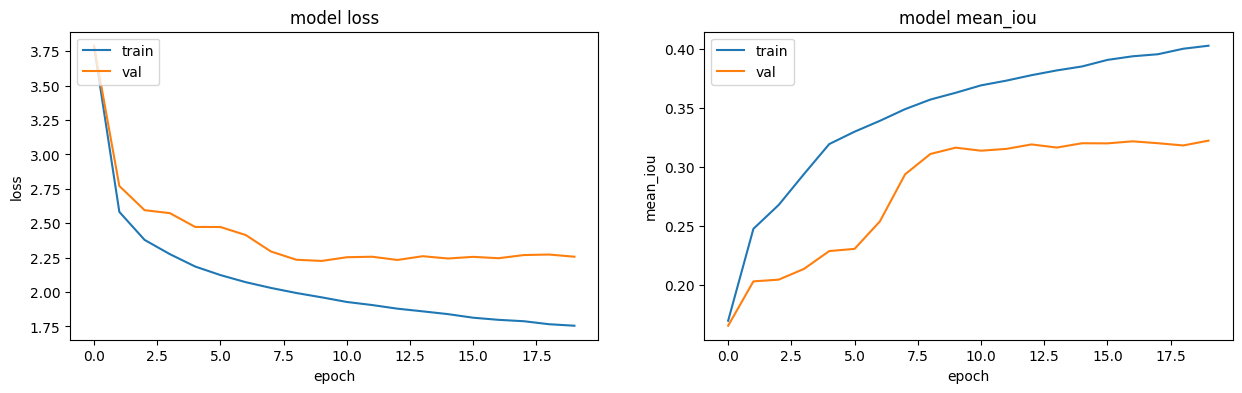

In [29]:
# Draw loss function and metric evolution
fc.draw_history(hist_df)

In [30]:
# Predict from model trained
y_pred_argmax = fc.predict_model(
    model,
    model_name,
    X_test,
    data_val,
    fc.total_loss,
    training_time,
    show_pred=False,
)

25/25 [==============================] - 18s 700ms/step - loss: 2.2568 - mean_iou: 0.3224
Pour le meilleur modèle on obtient :
mean_iou : 0.3224036693572998
loss : 2.25677752494812


1/1 [==============================] - 1s 1s/step


### 4.6 Modèles Resnet50 Unet avec augmentation des données

Maintenant on vas utiliser le modèle ResNet50 avec augmentation des données.

In [31]:
# Build model
model = md.build_resnet50(INPUT_SHAPE, N_CLASS)
model_name = model.name + "_augmented"

In [32]:
# Train model
print(f"Modèle : {model_name}")
model, hist_df, training_time = fc.train_model(
    model,
    model_name,
    data_train,
    data_train_augmented,
    data_val_augmented,
    data_val,
    X_test,
    fc.total_loss,
    True,
)

Modèle : ResNet50_U-Net_augmented
Epoch 1/20
297/297 [==============================] - 80s 248ms/step - loss: 3.9556 - mean_iou: 0.1934 - val_loss: 3.0607 - val_mean_iou: 0.2153
Epoch 2/20
297/297 [==============================] - 82s 275ms/step - loss: 2.5206 - mean_iou: 0.3507 - val_loss: 2.5608 - val_mean_iou: 0.2529
Epoch 3/20
297/297 [==============================] - 84s 281ms/step - loss: 2.2099 - mean_iou: 0.3882 - val_loss: 2.2770 - val_mean_iou: 0.3519
Epoch 4/20
297/297 [==============================] - 83s 277ms/step - loss: 2.0366 - mean_iou: 0.4329 - val_loss: 2.0390 - val_mean_iou: 0.4260
Epoch 5/20
297/297 [==============================] - 83s 280ms/step - loss: 1.9068 - mean_iou: 0.4508 - val_loss: 1.9450 - val_mean_iou: 0.4389
Epoch 6/20
297/297 [==============================] - 81s 272ms/step - loss: 1.8207 - mean_iou: 0.4596 - val_loss: 1.8773 - val_mean_iou: 0.4483
Epoch 7/20
297/297 [==============================] - 81s 273ms/step - loss: 1.7587 - mean_iou: 

INFO:tensorflow:Assets written to: ../model/checkpoint/ResNet50_U-Net_augmented\assets


INFO:tensorflow:Assets written to: ../model/checkpoint/ResNet50_U-Net_augmented\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpdhn9mwhc\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpdhn9mwhc\assets


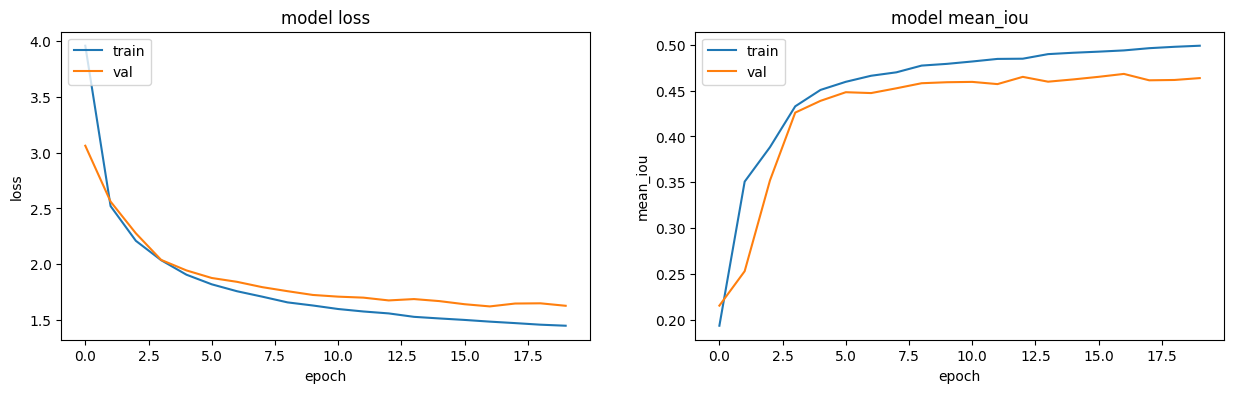

In [33]:
# Draw loss function and metric evolution
fc.draw_history(hist_df)

In [34]:
# Predict from model trained
y_pred_argmax = fc.predict_model(
    model,
    model_name,
    X_test,
    data_val,
    fc.total_loss,
    training_time,
    show_pred=False,
)

25/25 [==============================] - 21s 811ms/step - loss: 2.4630 - mean_iou: 0.2914
Pour le meilleur modèle on obtient :
mean_iou : 0.2913838326931
loss : 2.4630086421966553


1/1 [==============================] - 0s 472ms/step


### 4.7 Modèle Vgg16 avec augmentation des données

VGG16 est un modèle de réseau neuronal convolutif profond développé par l'Université d'Oxford. Il est connu pour sa simplicité et sa capacité à traiter des images de grande taille. 
Dans notre cas, nous allons utiliser le modèle VGG16 avec une technique appelée augmentation des données. 

In [35]:
# Build model
model = md.build_vgg16_unet(INPUT_SHAPE, N_CLASS)
model_name = model.name + "_augmentation"

In [36]:
# Train model
print(f"Modèle : {model_name}")
model, hist_df, training_time = fc.train_model(
    model,
    model_name,
    data_train,
    data_train_augmented,
    data_val_augmented,
    data_val,
    X_test,
    fc.total_loss,
    True,
)

Modèle : VGG16_U-Net_augmentation
Epoch 1/20
297/297 [==============================] - 92s 289ms/step - loss: 4.1087 - mean_iou: 0.1428 - val_loss: 3.6205 - val_mean_iou: 0.1671
Epoch 2/20
297/297 [==============================] - 85s 284ms/step - loss: 2.7508 - mean_iou: 0.2720 - val_loss: 2.7445 - val_mean_iou: 0.2766
Epoch 3/20
297/297 [==============================] - 87s 290ms/step - loss: 2.3616 - mean_iou: 0.3354 - val_loss: 2.3485 - val_mean_iou: 0.3411
Epoch 4/20
297/297 [==============================] - 86s 287ms/step - loss: 2.1497 - mean_iou: 0.3816 - val_loss: 2.1603 - val_mean_iou: 0.3779
Epoch 5/20
297/297 [==============================] - 89s 297ms/step - loss: 1.9495 - mean_iou: 0.4135 - val_loss: 1.9616 - val_mean_iou: 0.4076
Epoch 6/20
297/297 [==============================] - 88s 295ms/step - loss: 1.8504 - mean_iou: 0.4340 - val_loss: 1.9321 - val_mean_iou: 0.4172
Epoch 7/20
297/297 [==============================] - 89s 298ms/step - loss: 1.7772 - mean_iou: 

INFO:tensorflow:Assets written to: ../model/checkpoint/VGG16_U-Net_augmentation\assets


INFO:tensorflow:Assets written to: ../model/checkpoint/VGG16_U-Net_augmentation\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpj94xf18e\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpj94xf18e\assets


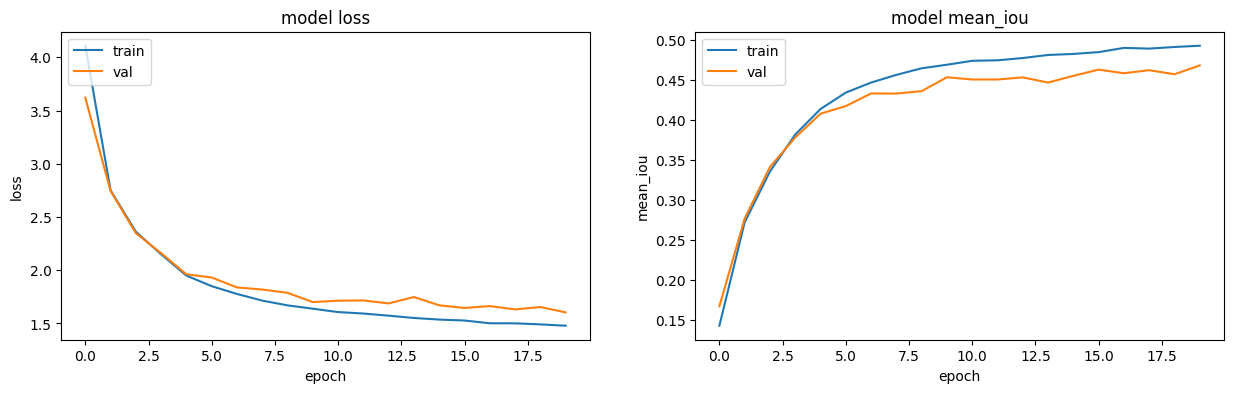

In [37]:
# Draw loss function and metric evolution
fc.draw_history(hist_df)

In [38]:
# Predict from model trained
y_pred_argmax = fc.predict_model(
    model,
    model_name,
    X_test,
    data_val,
    fc.total_loss,
    training_time,
    show_pred=False,
)

25/25 [==============================] - 20s 703ms/step - loss: 2.3977 - mean_iou: 0.2835
Pour le meilleur modèle on obtient :
mean_iou : 0.28353098034858704
loss : 2.397742509841919
1/1 [==============================] - 0s 149ms/step


### 4.8 Modèle Vgg19 avec augmentation des données

VGG19 est une variante du modèle de réseau neuronal convolutif VGG, développé par l'Université d'Oxford. Comme son nom l'indique, VGG19 comprend 19 couches avec des poids entraînables : 16 couches de convolution, suivies de 3 couches entièrement connectées. 

Comparé à VGG16, VGG19 est plus profond et a plus de paramètres entraînables. Cela peut potentiellement permettre au modèle d'apprendre des représentations plus complexes des données, mais aussi augmenter le risque de surapprentissage et nécessiter plus de ressources de calcul.

In [39]:
# Build model
model = md.build_vgg19_unet(INPUT_SHAPE, N_CLASS)
model_name = model.name + "_augmented"

In [40]:
# Train model
print(f"Modèle : {model_name}")
model, hist_df, training_time = fc.train_model(
    model,
    model_name,
    data_train,
    data_train_augmented,
    data_val_augmented,
    data_val,
    X_test,
    fc.total_loss,
    True,
)

Modèle : VGG19_U-Net_augmented
Epoch 1/20
297/297 [==============================] - 81s 268ms/step - loss: 4.1944 - mean_iou: 0.1795 - val_loss: 3.9071 - val_mean_iou: 0.1394
Epoch 2/20
297/297 [==============================] - 79s 264ms/step - loss: 2.5913 - mean_iou: 0.3308 - val_loss: 2.3935 - val_mean_iou: 0.3328
Epoch 3/20
297/297 [==============================] - 79s 265ms/step - loss: 2.1619 - mean_iou: 0.3834 - val_loss: 2.1215 - val_mean_iou: 0.3764
Epoch 4/20
297/297 [==============================] - 78s 263ms/step - loss: 2.0095 - mean_iou: 0.4150 - val_loss: 1.9917 - val_mean_iou: 0.4129
Epoch 5/20
297/297 [==============================] - 79s 265ms/step - loss: 1.8828 - mean_iou: 0.4429 - val_loss: 1.9057 - val_mean_iou: 0.4303
Epoch 6/20
297/297 [==============================] - 78s 263ms/step - loss: 1.7830 - mean_iou: 0.4562 - val_loss: 1.8440 - val_mean_iou: 0.4376
Epoch 7/20
297/297 [==============================] - 79s 263ms/step - loss: 1.7196 - mean_iou: 0.4

INFO:tensorflow:Assets written to: ../model/checkpoint/VGG19_U-Net_augmented\assets


INFO:tensorflow:Assets written to: ../model/checkpoint/VGG19_U-Net_augmented\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpwbzvxwvc\assets


INFO:tensorflow:Assets written to: C:\Users\Zacca\AppData\Local\Temp\tmpwbzvxwvc\assets


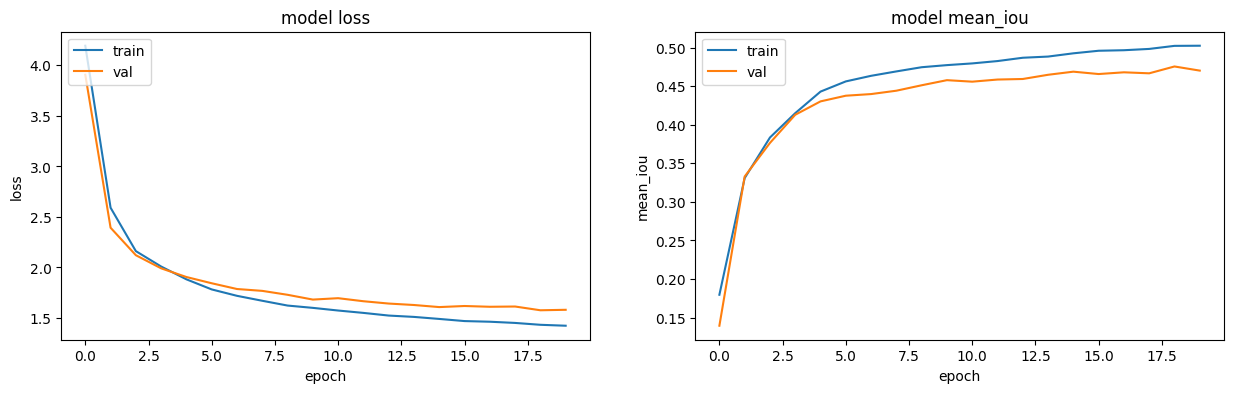

In [41]:
# Draw loss function and metric evolution
fc.draw_history(hist_df)

In [42]:
# Predict from model trained
y_pred_argmax = fc.predict_model(
    model,
    model_name,
    X_test,
    data_val,
    fc.total_loss,
    training_time,
    show_pred=False,
)

25/25 [==============================] - 18s 709ms/step - loss: 2.4079 - mean_iou: 0.2888
Pour le meilleur modèle on obtient :
mean_iou : 0.2887718081474304
loss : 2.4078574180603027
1/1 [==============================] - 0s 147ms/step


### 5. Comparaison des modèles

In [43]:
df = fc.load_model_histories("../model/history/", "../model/checkpoint/")

In [44]:
# Sort the DataFrame by 'mean_iou' in descending order
df_sorted = df.sort_values("mean_iou", ascending=False)

# Drop duplicates based on 'model_name', keep the first occurrence (the best one)
df_unique = df_sorted.drop_duplicates(subset="model_name", keep="first")

# Get the top 5 rows and reset the index
top_8_unique = df_unique.head(8).reset_index(drop=True)

# Define a new column order with 'model_name' as the first column
column_order = ["model_name"] + [
    col for col in top_8_unique.columns if col != "model_name"
]

# Reorder the columns
top_8_unique = top_8_unique[column_order]

top_8_unique

,model_name,loss,mean_iou,val_loss,val_mean_iou,train_time
0,VGG19_U-Net_augmented,1.423802,0.502446,1.581365,0.470176,0h 26m 23s
1,ResNet50_U-Net_augmented,1.450111,0.499013,1.628539,0.463674,0h 27m 56s
2,VGG16_U-Net_augmentation,1.479066,0.492564,1.604223,0.467906,0h 28m 40s
3,ResNet50_U-Net_basic,1.755224,0.402974,2.256786,0.322404,0h 21m 23s
4,Mini_U-Net_augmentation,3.158147,0.247017,3.172753,0.236163,0h 21m 36s
5,Mini_U-Net_total_loss,3.818119,0.169700,3.764494,0.161277,0h 19m 44s
6,Mini_U-Net_basic,1.592793,0.167420,1.607450,0.160027,0h 19m 11s
7,Mini_U-Net_dice_loss,0.705119,0.165070,0.671962,0.148464,0h 19m 41s


Le tableau ci-dessus présente les résultats de l'évaluation de huit modèles de réseaux de neurones différents. Les modèles ont été évalués sur plusieurs métriques, y compris la perte ('loss'), la perte de validation ('val_loss'), le temps d'entraînement ('train_time') et surtout, le 'mean_iou' qui est une mesure de la qualité de la segmentation effectuée par le modèle.

1. **VGG19_U-Net_augmented**: Ce modèle a obtenu le meilleur score IOU moyen sur l'ensemble de validation (0.470176). Le temps d'entraînement était de 26 minutes et 23 secondes.

2. **ResNet50_U-Net_augmented**: Ce modèle a obtenu le deuxième meilleur score IOU moyen sur l'ensemble de validation (0.463674). Le temps d'entraînement était de 27 minutes et 56 secondes.

3. **VGG16_U-Net_augmentation**: Ce modèle a obtenu le troisième meilleur score IOU moyen sur l'ensemble de validation (0.467906). Le temps d'entraînement était de 28 minutes et 40 secondes.

4. **ResNet50_U-Net_basic**: Ce modèle a obtenu un score IOU moyen de 0.322404 sur l'ensemble de validation. Le temps d'entraînement était de 21 minutes et 23 secondes.

5. **Mini_U-Net_augmentation**: Ce modèle a obtenu un score IOU moyen de 0.236163 sur l'ensemble de validation. Le temps d'entraînement était de 21 minutes et 36 secondes.

6. **Mini_U-Net_total_loss**: Ce modèle a obtenu un score IOU moyen de 0.161277 sur l'ensemble de validation. Le temps d'entraînement était de 19 minutes et 44 secondes.

7. **Mini_U-Net_basic**: Ce modèle a obtenu un score IOU moyen de 0.160027 sur l'ensemble de validation. Le temps d'entraînement était de 19 minutes et 11 secondes.

8. **Mini_U-Net_dice_loss**: Ce modèle a obtenu le score IOU moyen le plus bas sur l'ensemble de validation (0.148464). Le temps d'entraînement était de 19 minutes et 41 secondes.



### 6. Choix du modèle

Lorsqu'on compare l'utilisation de ResNet50 et de VGG, plusieurs facteurs nous orientent vers le choix de ResNet50. Tout d'abord, ResNet50 est un réseau plus profond que VGG, ce qui lui permet d'apprendre des caractéristiques plus complexes. De plus, ResNet50 introduit les connexions résiduelles, également appelées connexions de saut, qui facilitent l'apprentissage à partir de couches supplémentaires sans subir le problème de gradient qui s'évanouit. Cela constitue un avantage notable par rapport à VGG.

Sur le plan de l'efficacité computationnelle, ResNet50 surpasse également VGG. Il utilise un pooling moyen global plutôt que des couches entièrement connectées à la fin du réseau, ce qui réduit la taille du modèle et les calculs nécessaires. En termes de performance, ResNet50 a souvent démontré une supériorité par rapport à VGG, avec une meilleure généralisation aux nouvelles données et une moindre tendance au surajustement.

Enfin, ResNet50, lorsqu'il est pré-entraîné sur ImageNet, est largement utilisé pour l'apprentissage par transfert dans diverses tâches et montre d'excellentes performances. Il s'avère donc être un choix judicieux pour notre tâche. Cependant, il est important de noter que le choix du modèle dépend toujours de la tâche spécifique et des ressources computationnelles disponibles. Il est toujours bénéfique d'expérimenter avec différentes architectures pour déterminer celle qui fonctionne le mieux pour votre cas d'utilisation spécifique.